In [1]:
%matplotlib inline

In [2]:
# Import training data
import matplotlib.pyplot as plt
import csv
import numpy as np

np.random.seed(0)

def import_csv(csvfile):
    """
    Imports the CSV file as an array of lines
    
    :param csvfile: The path of the CSV file
    :return lines: The lines of the CSV file 
    """
    lines = []
    with open(log_path) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)

    return lines

data_path = './data/'
img_path = data_path + 'IMG/'
log_path = data_path + 'driving_log.csv'

# Store the lines of the CSV file in an array
lines = import_csv(log_path)

# Remove the first line of the array
lines.pop(0)

# Transform to a relative path to the images
for line in lines:
    line[0] = line[0].split('/')[-1]
    line[1] = line[1].split('/')[-1]
    line[2] = line[2].split('/')[-1]
    
# Make lines a numpy array
lines = np.asarray(lines)
    
# Test to make sure we read that properly
print(lines[0])
print(lines.shape)

['center_2016_12_01_13_30_48_287.jpg' 'left_2016_12_01_13_30_48_287.jpg'
 'right_2016_12_01_13_30_48_287.jpg' ' 0' ' 0' ' 0' ' 22.14829']
(8036, 7)


In [3]:
# Split data into training and validation sets
from sklearn.model_selection import train_test_split

X = lines[:,0:3]
y = lines[:,3]

# Convert steering values to float
y = y.astype(np.float32)

test_size = 0.2
random_state = 0

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=random_state)

# Confirmation
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

print(X_train[0])
print(y_train[0])

(6428, 3)
(6428,)
(1608, 3)
(1608,)
['center_2016_12_01_13_43_40_097.jpg' 'left_2016_12_01_13_43_40_097.jpg'
 'right_2016_12_01_13_43_40_097.jpg']
0.0


In [4]:
# Build the model
from keras.models import Sequential
from keras.layers import Lambda, Dropout, Conv2D, Dense, MaxPooling2D, Flatten

keep_prob = 0.5
height = 66
width = 200
num_channels = 3

model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.0, input_shape=(height, width, num_channels)))
model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Dropout(keep_prob))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))

model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 66, 200, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 47, 36)    21636       convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 5, 22, 48)     43248       convolution2d_2[0][0]            
___________________________________________________________________________________________

In [5]:
# Functions to process the images
from utils import *

In [6]:
# Build the generator
def generator(data_dir, image_paths, steer_angles, batch_size, is_training):
    """
    Generator to process a certain portion of the model at a time
    
    :param data_dir: The data directory
    :param image_paths: The paths to the images
    :param steer_angles: The steering angles
    :param batch_size: The batch size
    :param is_training: Whether this is training data (True) or validation data (False)
    """
    images = np.empty([batch_size, height, width, num_channels])
    steering = np.empty(batch_size)
    
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steer_angles[index]
            
            if is_training and np.random.rand() < 0.6:
                image, steering_angle = augment_image(data_dir, center, left, right, steering_angle)
            else:
                image = load_image(data_dir, center) 
                
            image = preprocess(image)
            
            images[i] = image
            steering[i] = steering_angle
            
            # debug
            #print(image.shape)
            
            i += 1
            if i == batch_size:
                break
                
        yield images, steering
        
# Plot function to be called after running the model
def plot_results(history, num=0):
    """
    Plot the results 
    
    :param history: The fit model
    :param num: The number for the output file to save to
    """
    # Plot training and validation loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.savefig('training_validation_loss_plot_' + str(num) + '.jpg')
    plt.show()
    plt.close()

Epoch 1/10


/home/carnd/CarND-Behavioral-Cloning-P3/utils.py:53: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 160 but corresponding boolean dimension is 66
  mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1


20000/20000 [==============================] - 155s - loss: 0.0339 - val_loss: 0.0117

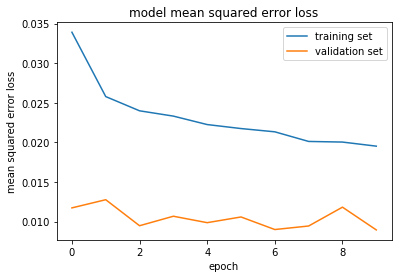

In [7]:
# Train the model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

batch_size = 40
num_epochs = 10
samples_per_epoch = 20000
learn_rate = 0.0001

checkpoint = ModelCheckpoint('model-{epoch:03d}.h0',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='auto')

model.compile(loss='mean_squared_error', optimizer=Adam(lr=learn_rate))

history = model.fit_generator(generator(img_path, X_train, y_train, batch_size, True),
                    samples_per_epoch,
                    num_epochs,
                    max_q_size=1,
                    validation_data=generator(img_path, X_valid, y_valid, batch_size, False),
                    nb_val_samples=len(X_valid),
                    callbacks=[checkpoint],
                    verbose=1)

plot_results(history, 0)